In [1]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from sklearn.metrics import mean_squared_error
from skimage.transform import resize
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d
from skimage import util
from skimage.restoration import richardson_lucy as rl
from PIL import Image
from IPython.display import display



In [154]:

def gaussian_blur(img, kernel_size = 3):

    dummy = np.copy(img)

    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy


def motion_blur(img,  kernel_size = 3):

    dummy = np.copy(img)

    h = np.eye(kernel_size) / kernel_size

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

def inverse_filter(img, kernel):
    kernel /= np.sum(kernel)
    
   
    dummy = np.copy(img)
    dummy = fft2(dummy)
    
   
    kernel = fft2(kernel, s=img.shape)

    epsilon = 1e-8
    kernel[np.abs(kernel) < epsilon] = epsilon  
    
   
    dummy = dummy / kernel
    
    
    dummy = np.abs(ifft2(dummy))
    
    return dummy  

def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    
    dummy = np.copy(img)
    
    # Perform Fourier transform on the image to convert it to the frequency domain
    dummy = fft2(dummy)
    
    kernel = fft2(kernel, s=img.shape)
    
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    
    dummy = dummy * kernel
    
    # Perform inverse Fourier transform to bring the result back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    return dummy


def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h
def motion_kernel(kernel_size=3):
    h = np.eye(kernel_size) / kernel_size
    return h

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Choosing which image to apply the blurs and filters

In [ ]:
file_name = os.path.join('braintumor.jpg') 
img = rgb2gray(plt.imread(file_name))

Code showing the implementation of adding motion blur and different additive noises

In [155]:


# motion blurred image
motion_blurred_img = motion_blur(img,  kernel_size = 3)

# normalizing the blurred image
motion_blurred_img = (motion_blurred_img - np.min(motion_blurred_img)) / (np.max(motion_blurred_img) - np.min(motion_blurred_img))

# kernel to be used as argument to the filters
motion_kernel = motion_kernel(3)

# adding gaussian noise to motion blurred image
motion_noisy_img = util.random_noise(motion_blurred_img, mode="gaussian", var=0.01)

# adding poisson noise to motion blurred image
motion_noisy_img2 = util.random_noise(motion_blurred_img, mode="poisson")



Showing Motion Blurred Image with Additive Noises

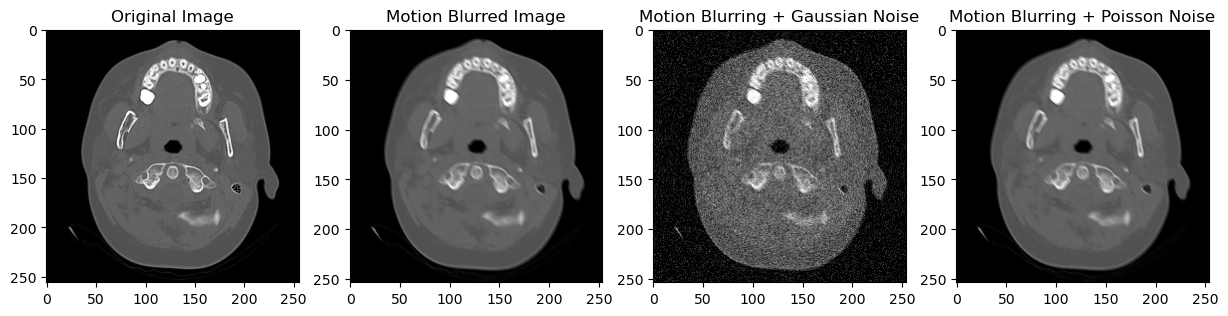

In [156]:
display = [img, motion_blurred_img, motion_noisy_img,motion_noisy_img2]
label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Motion Blurring + Poisson Noise']

fig = plt.figure(figsize=(15, 5))  

for i in range(len(display)):
    fig.add_subplot(1, 4, i+1)  
    plt.imshow(display[i], cmap='gray')
    plt.title(label[i])

plt.show()


In [157]:

# gaussian blurred image
gaussian_blurred_img = gaussian_blur(img,  kernel_size = 3)

# Normalizing the gaussian blurred image
gaussian_blurred_img = (gaussian_blurred_img - np.min(gaussian_blurred_img)) / (np.max(gaussian_blurred_img) - np.min(gaussian_blurred_img))

# gaussian kernel to be used as argument to filter
gaussian_kernel = gaussian_kernel(3)

# adding gaussian noise to gaussian blurred image
gaussian_noisy_img = util.random_noise(gaussian_blurred_img, mode="gaussian", var=0.01)

# adding poisson noise to poisson blurred image
gaussian_noisy_img2 = util.random_noise(gaussian_blurred_img, mode="poisson")


Displaying Gaussian Blurred Images with additive noises

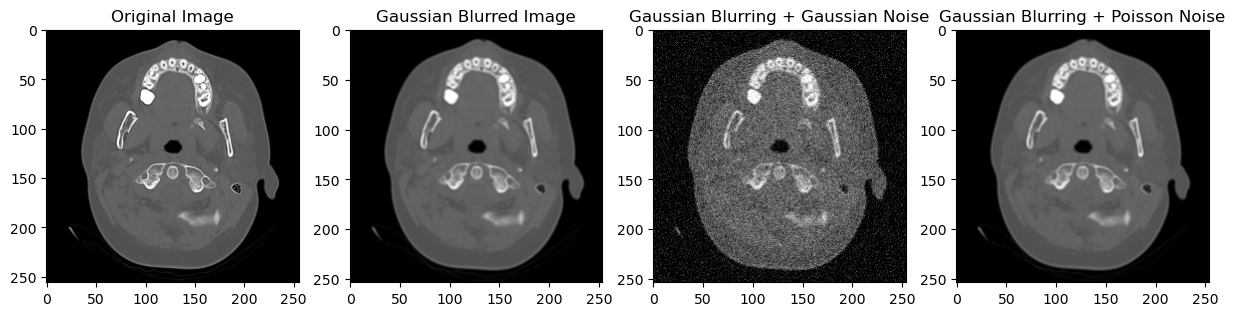

In [158]:
display = [img, gaussian_blurred_img, gaussian_noisy_img, gaussian_noisy_img2]
label = ['Original Image', 'Gaussian Blurred Image', 'Gaussian Blurring + Gaussian Noise', 'Gaussian Blurring + Poisson Noise']

fig = plt.figure(figsize=(15, 5)) 

for i in range(len(display)):
    fig.add_subplot(1, 4, i+1) 
    plt.imshow(display[i], cmap='gray')
    plt.title(label[i])

plt.show()


Applying filters to images with Motion Blur

In [159]:

# applying the filters to images with motion blur + gaussian noise
m_inv_filtered_img = inverse_filter(motion_noisy_img,motion_kernel)
m_w_filtered_img = wiener_filter(motion_noisy_img, motion_kernel, K = 30)
m_rl_img = rl(motion_noisy_img,motion_kernel, 25)

# applying the filters to images with motion blur + poisson noise
m_inv_filtered_img2 = inverse_filter(motion_noisy_img2,motion_kernel)
m_w_filtered_img2 = wiener_filter(motion_noisy_img2, motion_kernel, K = 30)
m_rl_img2 = rl(motion_noisy_img2,motion_kernel, 25)

Applying filters to images with Gaussian Blur

In [160]:


# applying the filters to images with gaussian blur + gaussian noise
g_inv_filtered_img = inverse_filter(gaussian_noisy_img,gaussian_kernel)
g_w_filtered_img = wiener_filter(gaussian_noisy_img, gaussian_kernel, K = 30)
g_rl_img = rl(gaussian_noisy_img,gaussian_kernel, 25)

# applying the filters to images with gaussian blur + poisson noise
g_inv_filtered_img2 = inverse_filter(gaussian_noisy_img2,gaussian_kernel)
g_w_filtered_img2 = wiener_filter(gaussian_noisy_img2, gaussian_kernel, K = 30)
g_rl_img2 = rl(gaussian_noisy_img2,gaussian_kernel, 25)

Displaying the images with Filters applied with Motion Blur

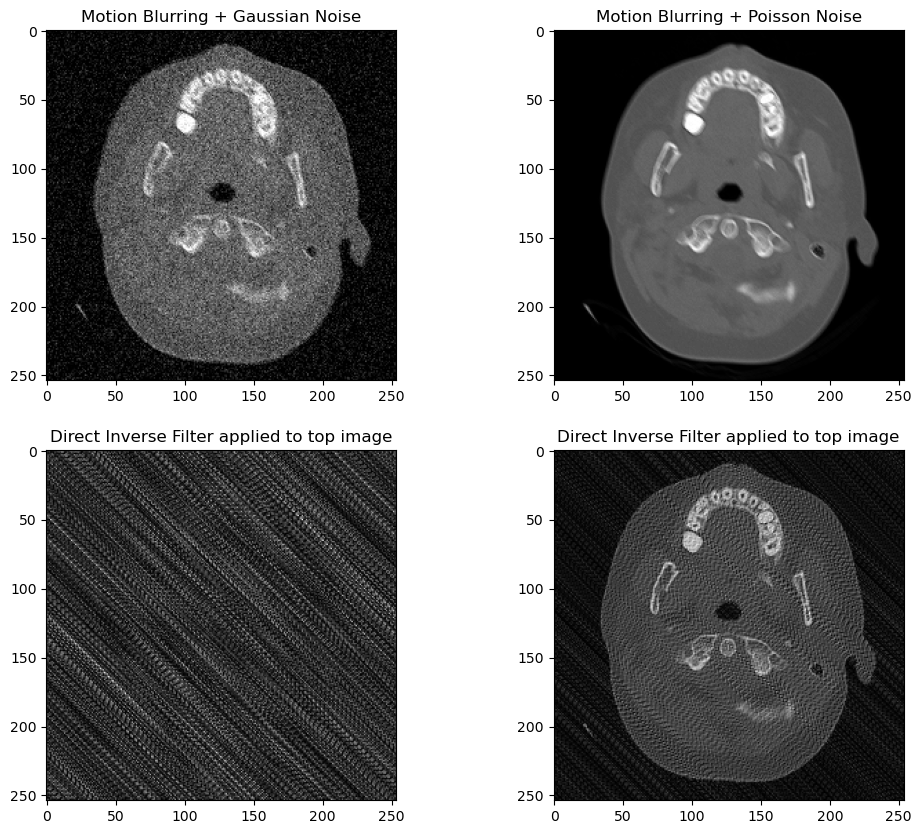

In [161]:
display = [ motion_noisy_img, motion_noisy_img2,  m_inv_filtered_img,m_inv_filtered_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Direct Inverse Filter applied to top image', 'Direct Inverse Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Applying Direct Inverse Filter to Gaussian Blurred Images

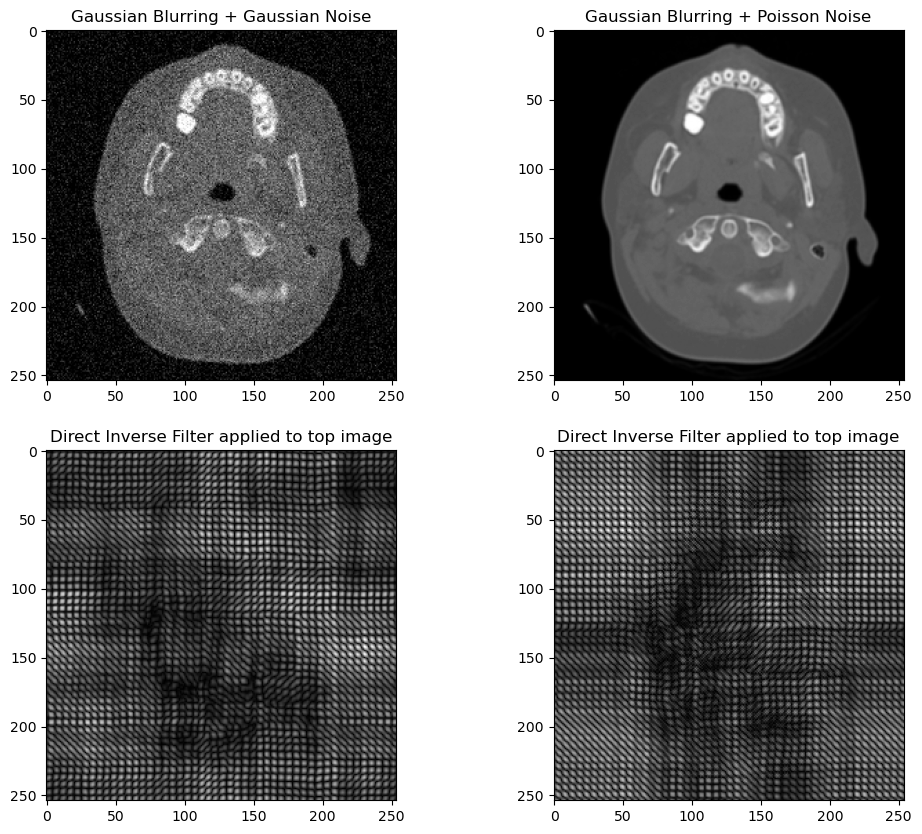

In [164]:
display = [ gaussian_noisy_img, gaussian_noisy_img2, g_inv_filtered_img, g_inv_filtered_img2]
label = [ 'Gaussian Blurring + Gaussian Noise','Gaussian Blurring + Poisson Noise', 'Direct Inverse Filter applied to top image', 'Direct Inverse Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

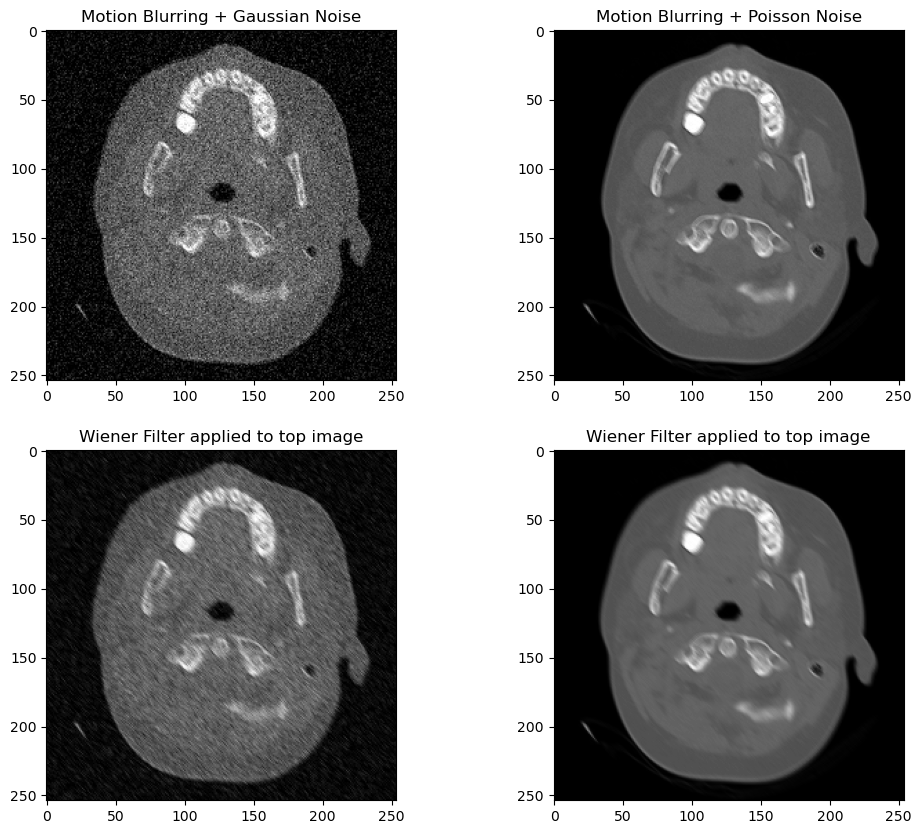

In [165]:
display = [ motion_noisy_img, motion_noisy_img2,  m_w_filtered_img, m_w_filtered_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Wiener Filter applied to top image', 'Wiener Filter applied to top image']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Richardson-Lucy Algorithm Applied to images with Motion Blur

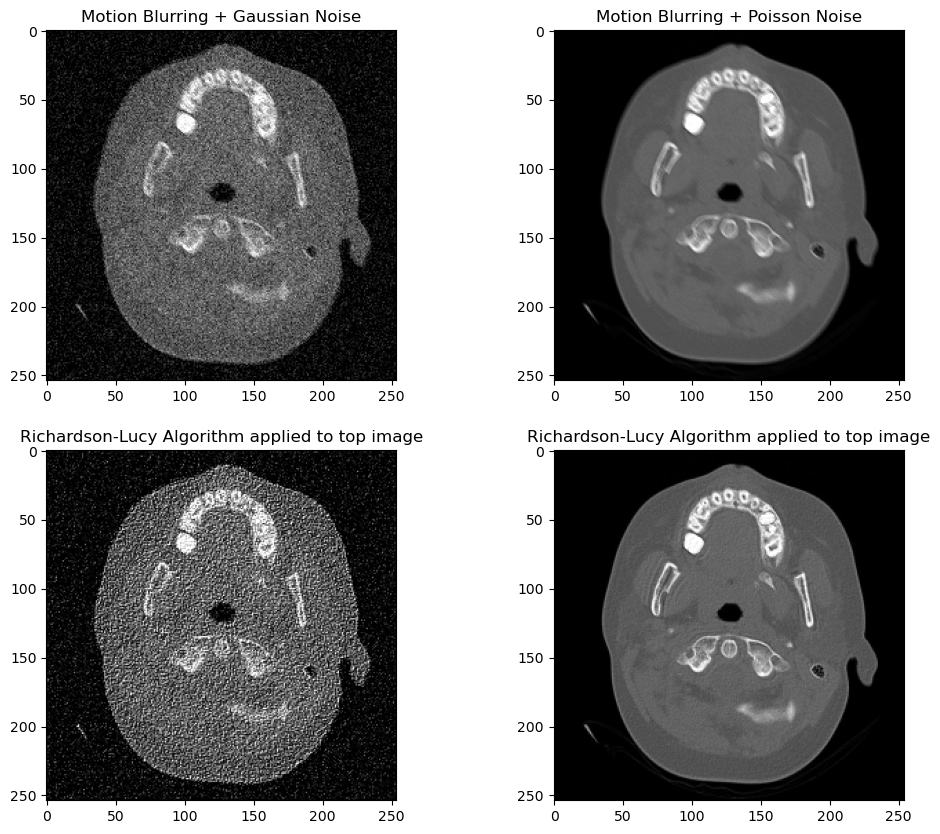

In [166]:

display = [motion_noisy_img, motion_noisy_img2,  m_rl_img, m_rl_img2]
label = [ 'Motion Blurring + Gaussian Noise','Motion Blurring + Poisson Noise', 'Richardson-Lucy Algorithm applied to top image', 'Richardson-Lucy Algorithm applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Richardson-Lucy Algorithm Applied to images with Gaussian Blur

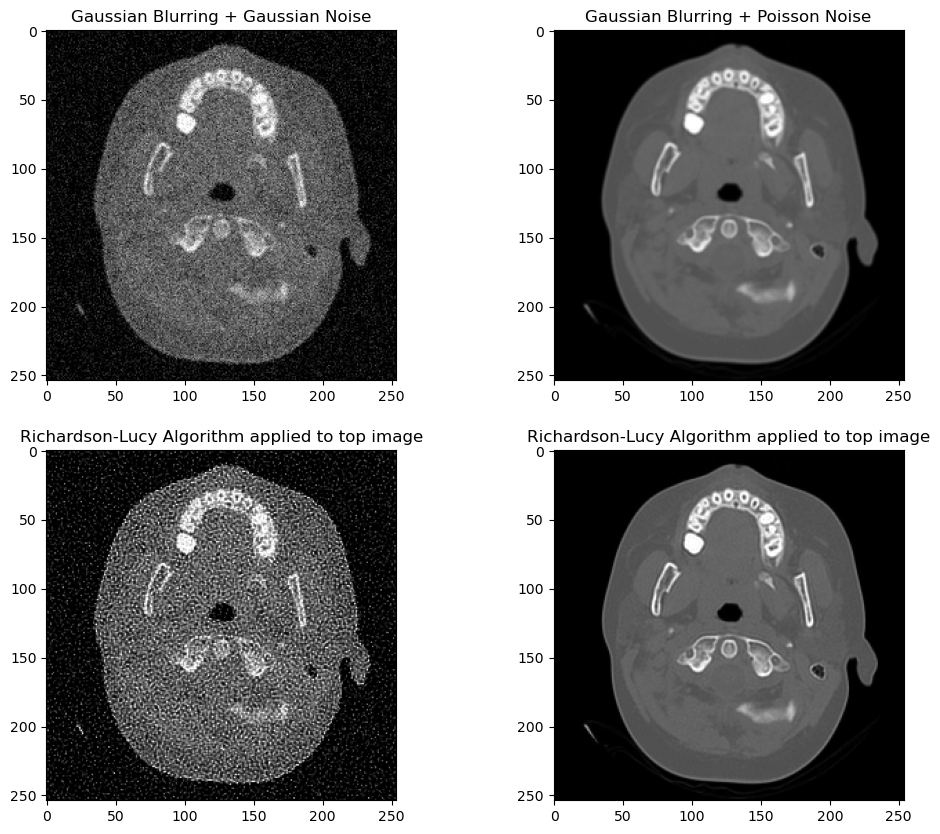

In [167]:


display = [gaussian_noisy_img, gaussian_noisy_img2,  g_rl_img, g_rl_img2]
label = [ 'Gaussian Blurring + Gaussian Noise','Gaussian Blurring + Poisson Noise', 'Richardson-Lucy Algorithm applied to top image', 'Richardson-Lucy Algorithm applied to top image']


fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

Code in Calculating PSNR and SSIM for the applied filters

In [168]:

# resizing the restored images so the psnr and ssim can be calculated
m_inv_filtered_img = resize(m_inv_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
m_w_filtered_img = resize(m_w_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
m_rl_img = resize(m_rl_img, img.shape, mode='reflect', anti_aliasing=True)

# resizing the restored images so the psnr and ssim can be calculated
m_inv_filtered_img2 = resize(m_inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
m_w_filtered_img2 = resize(m_w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
m_rl_img2 = resize(m_rl_img2, img.shape, mode='reflect', anti_aliasing=True)



g_inv_filtered_img = resize(g_inv_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
g_w_filtered_img = resize(g_w_filtered_img, img.shape, mode='reflect', anti_aliasing=True)
g_rl_img = resize(g_rl_img, img.shape, mode='reflect', anti_aliasing=True)

# resizing the restored images so the psnr and ssim can be calculated
g_inv_filtered_img2 = resize(g_inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
g_w_filtered_img2 = resize(g_w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
g_rl_img2 = resize(g_rl_img2, img.shape, mode='reflect', anti_aliasing=True)



data_range = 255.0


Calculating PSNR Values

In [169]:
# Calculate PSNR for Motion blur + Gaussian Noise
m_inv_filtered_psnr_value = peak_signal_noise_ratio(img, m_inv_filtered_img, data_range=data_range)
m_w_psnr_value = peak_signal_noise_ratio(img, m_w_filtered_img, data_range=data_range)
m_rl_psnr_value = peak_signal_noise_ratio(img, m_rl_img, data_range=data_range)

# Calculate PSNR for Motion blur +  Poisson Noise
m_inv_filtered_psnr_value2 = peak_signal_noise_ratio(img, m_inv_filtered_img2, data_range=data_range)
m_w_psnr_value2 = peak_signal_noise_ratio(img, m_w_filtered_img2, data_range=data_range)
m_rl_psnr_value2 = peak_signal_noise_ratio(img, m_rl_img2, data_range=data_range)

# Calculate PSNR for Gaussian blur + Gaussian Noise
g_inv_filtered_psnr_value = peak_signal_noise_ratio(img, g_inv_filtered_img, data_range=data_range)
g_w_psnr_value = peak_signal_noise_ratio(img, g_w_filtered_img, data_range=data_range)
g_rl_psnr_value = peak_signal_noise_ratio(img, g_rl_img, data_range=data_range)

# Calculate PSNR for Gaussian blur +  Poisson Noise
g_inv_filtered_psnr_value2 = peak_signal_noise_ratio(g_inv_filtered_img2,img, data_range=data_range)
g_w_psnr_value2 = peak_signal_noise_ratio(img, g_w_filtered_img2, data_range=data_range)
g_rl_psnr_value2 = peak_signal_noise_ratio(img, g_rl_img2, data_range=data_range)









Calculating SSIM Values

In [170]:
# Calculate SSIM for Motion blur + Gaussian Noise
m_inv_ssim = structural_similarity(img, m_inv_filtered_img, data_range=data_range)
m_w_ssim =  structural_similarity(img, m_w_filtered_img, data_range=data_range)
m_rl_ssim = structural_similarity(img, m_rl_img, data_range=data_range)

# Calculate SSIM for Motion blur + Poisson Noise
m_inv_ssim2 = structural_similarity(img, m_inv_filtered_img, data_range=data_range)
m_w_ssim2 =  structural_similarity(img, m_w_filtered_img, data_range=data_range)
m_rl_ssim2 = structural_similarity(img, m_rl_img, data_range=data_range)


# Calculate SSIM for Gaussian blur + Gaussian Noise
g_inv_ssim = structural_similarity(img, g_inv_filtered_img, data_range=data_range)
g_w_ssim =  structural_similarity(img, g_w_filtered_img, data_range=data_range)
g_rl_ssim = structural_similarity(img, g_rl_img, data_range=data_range)

# Calculate SSIM for Gaussian blur + Poisson Noise
g_inv_ssim2 = structural_similarity(img, g_inv_filtered_img, data_range=data_range)
g_w_ssim2 =  structural_similarity(img, g_w_filtered_img, data_range=data_range)
g_rl_ssim2 = structural_similarity(img, g_rl_img, data_range=data_range)

Motion Blur + Gaussian Noise PSNR AND SSIM

In [207]:
# printing PSNR for Filters applied to Motion Blur + Gaussian Noise
print("Motion Blur + Gaussian Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{m_inv_filtered_psnr_value:.5f}")
print(f"Wiener Filter PSNR: {m_w_psnr_value:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {m_rl_psnr_value:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter SSIM:{m_inv_ssim:.5f}")
print(f"Wiener Filter SSIM: {m_w_ssim:.5f}")
print(f"Richardson Lucy Algorithm SSIM: {m_rl_ssim:.5f}")



Motion Blur + Gaussian Noise
PSNR Values
Direct Inverse Filter PSNR:10.50240
Wiener Filter PSNR: 10.38124
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter SSIM:0.30247
Wiener Filter SSIM: 0.36136
Richardson Lucy Algorithm SSIM: 0.36461


Graphing PSNR and SSIM for Motion Blur + Gaussian Noise

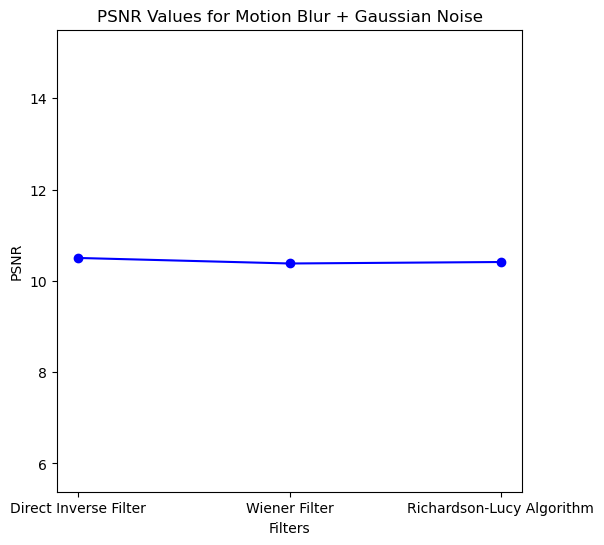

In [172]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [m_inv_filtered_psnr_value, m_w_psnr_value, m_rl_psnr_value]
ssim_values = [m_inv_ssim, m_w_ssim,m_rl_ssim]

plt.figure(figsize=(6, 6))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='blue')
plt.title('PSNR Values for Motion Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)

plt.show()


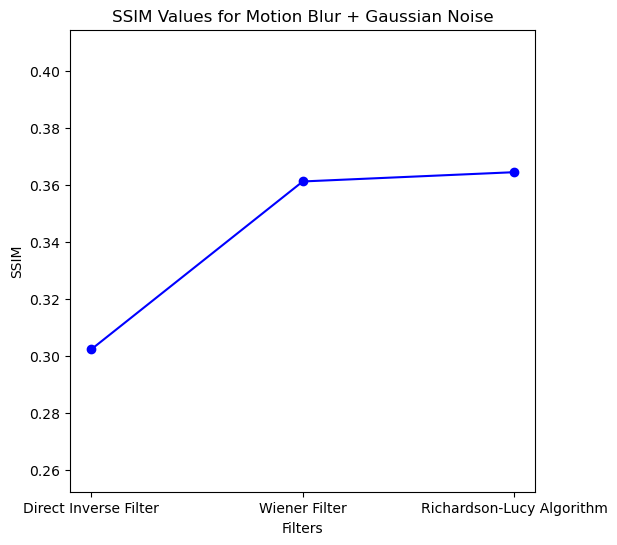

In [173]:
plt.figure(figsize=(6, 6))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Motion Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.05, max(ssim_values) + 0.05)

plt.show()

Motion Blur + Poisson Noise PSNR AND SSIM

In [208]:
# printing PSNR for Filters applied to Motion Blur + Poisson Noise
print("Motion Blur + Poisson Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{m_inv_filtered_psnr_value2:.5f}")
print(f"Wiener Inverse Filter PSNR: {m_w_psnr_value2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {m_rl_psnr_value2:.5}")
print()


# printing SSIM Filters applied to Motion Blur + Poisson Noise
print("SSIM Values")
print(f"Direct Inverse Filter SSIM:{m_inv_ssim2:.5f}")
print(f"Wiener Inverse Filter SSIM: {m_w_ssim2:.5f}")
print(f"Richardson Lucy Algorithm SSIM: {m_rl_ssim2:.5f}")


Motion Blur + Poisson Noise
PSNR Values
Direct Inverse Filter PSNR:10.41363
Wiener Inverse Filter PSNR: 10.38125
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter SSIM:0.30247
Wiener Inverse Filter SSIM: 0.36136
Richardson Lucy Algorithm SSIM: 0.36461


Graphing PSNR and SSIM for Motion Blur + Poisson Noise

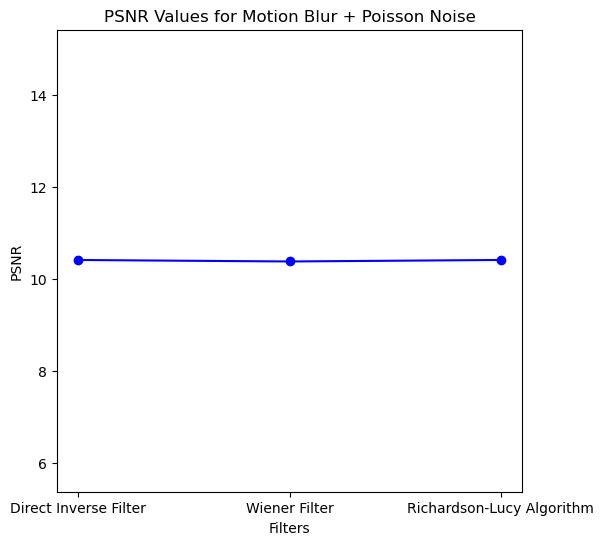

In [177]:
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [m_inv_filtered_psnr_value2, m_w_psnr_value2, m_rl_psnr_value2]
ssim_values = [m_inv_ssim2, m_w_ssim2,m_rl_ssim2]

plt.figure(figsize=(6, 6))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='blue')
plt.title('PSNR Values for Motion Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)


plt.show()


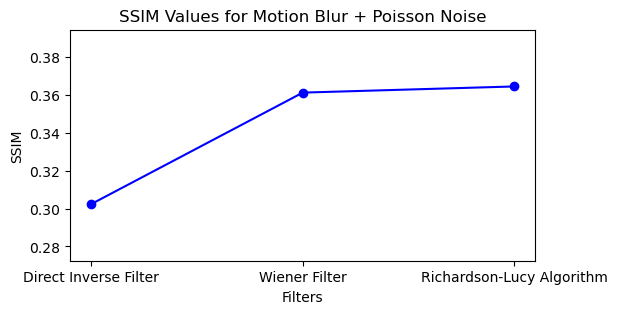

In [178]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Motion Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.03, max(ssim_values) + 0.03)

plt.show()

Gaussian Blur + Gaussian Noise PSNR AND SSIM

In [209]:
# printing PSNR for Filters applied to Gaussian Blur + Gaussian Noise
print("Gaussian Blur + Gaussian Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{g_inv_filtered_psnr_value:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_psnr_value:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_psnr_value:.5}")
print()


# printing SSIM Filters applied to Gaussian Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter SSIM:{g_inv_ssim:.5f}")
print(f"Wiener Inverse Filter SSIM: {g_w_ssim:.5f}")
print(f"Richardson Lucy Algorithm SSIM: {g_rl_ssim:.5f}")


Gaussian Blur + Gaussian Noise
PSNR Values
Direct Inverse Filter PSNR:8.31425
Wiener Inverse Filter PSNR: 10.38125
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter SSIM:0.01423
Wiener Inverse Filter SSIM: 0.36136
Richardson Lucy Algorithm SSIM: 0.36459


Graphing PSNR and SSIM for Gaussian Blur + Gaussian Noise

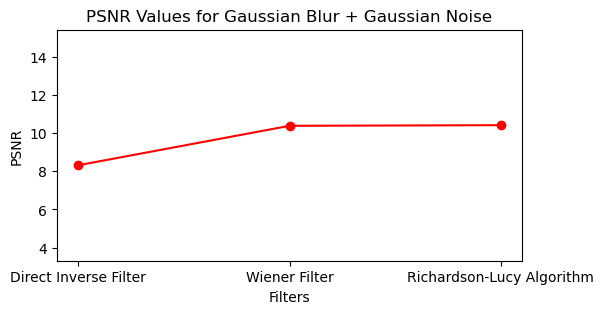

In [180]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [g_inv_filtered_psnr_value, g_w_psnr_value, g_rl_psnr_value]
ssim_values = [g_inv_ssim, g_w_ssim, g_rl_ssim]

plt.figure(figsize=(6, 3))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='red')
plt.title('PSNR Values for Gaussian Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)



plt.show()


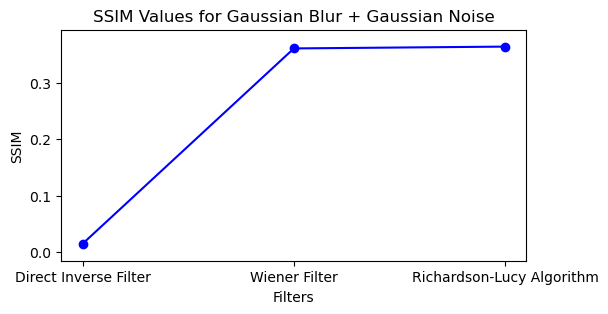

In [181]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Gaussian Blur + Gaussian Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.03, max(ssim_values) + 0.03)


plt.show()

Gaussian Blur + Poisson Noise PSNR AND SSIM

In [210]:
# printing PSNR for Filters applied to Gaussian Blur + Poisson Noise
print("Gaussian Blur + Poisson Noise")
print("PSNR Values")
print(f"Direct Inverse Filter PSNR:{g_inv_filtered_psnr_value2:.5f}")
print(f"Wiener Inverse Filter PSNR: {g_w_psnr_value2:.5f}")
print(f"Richardson Lucy Algorithm PSNR: {g_rl_psnr_value2:.5}")
print()


# printing SSIM Filters applied to Gaussian Blur + Gaussian Noise
print("SSIM Values")
print(f"Direct Inverse Filter SSIM:{g_inv_ssim2:.5f}")
print(f"Wiener Inverse Filter SSIM: {g_w_ssim2:.5f}")
print(f"Richardson Lucy Algorithm SSIM: {g_rl_ssim2:.5f}")


Gaussian Blur + Poisson Noise
PSNR Values
Direct Inverse Filter PSNR:10.54928
Wiener Inverse Filter PSNR: 10.38124
Richardson Lucy Algorithm PSNR: 10.414

SSIM Values
Direct Inverse Filter SSIM:0.01423
Wiener Inverse Filter SSIM: 0.36136
Richardson Lucy Algorithm SSIM: 0.36459


Graphing for Gaussian Blur + Poisson Noise

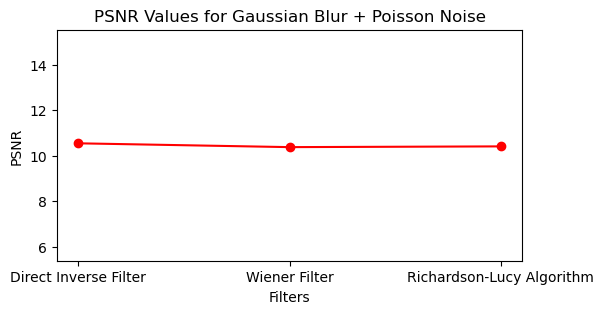

In [183]:
# Data for plotting
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [g_inv_filtered_psnr_value2, g_w_psnr_value2, g_rl_psnr_value2]
ssim_values = [g_inv_ssim2, g_w_ssim2, g_rl_ssim2]

plt.figure(figsize=(6, 3))

plt.plot(filters, psnr_values, marker='o', linestyle='-', color='red')
plt.title('PSNR Values for Gaussian Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('PSNR')
plt.ylim(min(psnr_values) - 5, max(psnr_values) + 5)


plt.show()


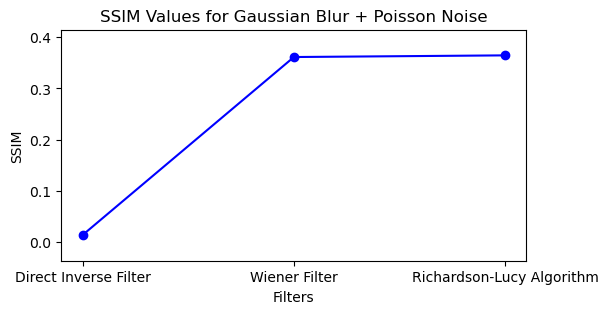

In [184]:
plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='blue')
plt.title('SSIM Values for Gaussian Blur + Poisson Noise')
plt.xlabel('Filters')
plt.ylabel('SSIM')
plt.ylim(min(ssim_values) - 0.05, max(ssim_values) + 0.05)
plt.show()

Taking average PSNR and SSIM Values

In [185]:
average_inv_psnr = (m_inv_filtered_psnr_value + m_inv_filtered_psnr_value2+g_inv_filtered_psnr_value+ g_inv_filtered_psnr_value2)/ 4.0
average_w_psnr = (m_w_psnr_value + m_w_psnr_value2+g_w_psnr_value+ g_w_psnr_value2)/ 4.0
average_rl_psnr = (m_rl_psnr_value + m_rl_psnr_value2+g_rl_psnr_value+ g_rl_psnr_value2)/ 4.0
 
average_inv_ssim = (m_inv_ssim + m_inv_ssim2 + g_inv_ssim + g_inv_ssim2)/ 4.0
average_w_ssim = (m_w_ssim + m_w_ssim2+g_w_ssim+ g_w_ssim2)/ 4.0
average_rl_ssim = (m_rl_ssim + m_rl_ssim2+g_rl_ssim+ g_rl_ssim2)/ 4.0


In [186]:
print(f"Average PSNR for Direct Inverse Filter: {average_inv_psnr:.7f}")
print(f"Average PSNR for Wiener Filter: {average_w_psnr:.7f}")
print(f"Average PSNR for Richarson-Lucy Algorithm: {average_rl_psnr:.7f}")
print()

print(f"Average SSIM for Direct Inverse Filter: {average_inv_ssim:.7f}")
print(f"Average SSIM for Wiener Filter: {average_w_ssim:.7f}")
print(f"Average SSIM for Richardson-Lucy Algorithm: {average_rl_ssim:.7f}")




Average PSNR for Direct Inverse Filter: 9.9448900
Average PSNR for Wiener Filter: 10.3812452
Average PSNR for Richarson-Lucy Algorithm: 10.4138939

Average SSIM for Direct Inverse Filter: 0.1583514
Average SSIM for Wiener Filter: 0.3613618
Average SSIM for Richardson-Lucy Algorithm: 0.3646042


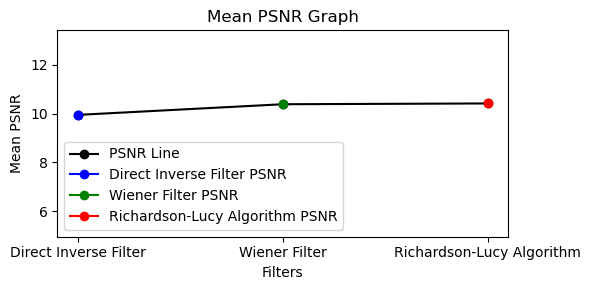

In [187]:

filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
psnr_values = [average_inv_psnr, average_w_psnr, average_rl_psnr]

colors = ['blue', 'green', 'red']

plt.figure(figsize=(6, 3))


plt.plot(filters, psnr_values, marker='o', linestyle='-', color='black', label='PSNR Line')


for i, filter_name in enumerate(filters):
    plt.plot(filter_name, psnr_values[i], marker='o', color=colors[i], label=f'{filter_name} PSNR')


plt.title('Mean PSNR Graph')
plt.xlabel('Filters')
plt.ylabel('Mean PSNR')


plt.ylim(min(psnr_values)-5, max(psnr_values) + 3)

plt.legend()


plt.tight_layout()
plt.show()



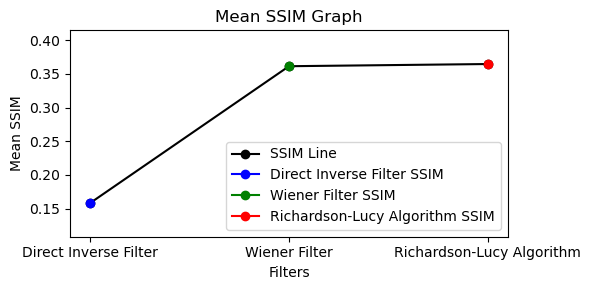

In [188]:
filters = ['Direct Inverse Filter', 'Wiener Filter', 'Richardson-Lucy Algorithm']
ssim_values = [average_inv_ssim, average_w_ssim, average_rl_ssim]


colors = ['blue', 'green', 'red']

plt.figure(figsize=(6, 3))

plt.plot(filters, ssim_values, marker='o', linestyle='-', color='black', label='SSIM Line')

for i, filter_name in enumerate(filters):
    plt.plot(filter_name, ssim_values[i], marker='o', color=colors[i], label=f'{filter_name} SSIM')

plt.title('Mean SSIM Graph')
plt.xlabel('Filters')
plt.ylabel('Mean SSIM')

plt.ylim(min(ssim_values) - 0.05, max(ssim_values) + 0.05)

plt.legend()

plt.tight_layout()
plt.show()
